# Initialize

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Classifier Libraries
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
import sys
import importlib

# Import and reload the module
sys.path.append("../")
import Scripts.data_process_utils as dpu
importlib.reload(dpu)

<module 'Scripts.data_process_utils' from "/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/Pennylane_Models/Don't Touch/Model_Final_Pennylane_Keras_QNN_11_Features_6M_DS/../../../Scripts/data_process_utils.py">

In [ ]:
import Scripts.evaluation_functions as eval
import importlib
importlib.reload(eval)

<module 'Scripts.evaluation_functions' from "/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/Pennylane_Models/Don't Touch/Model_Final_Pennylane_Keras_QNN_11_Features_6M_DS/../../../Scripts/evaluation_functions.py">

# Data Loading

In [ ]:
finance_df=pd.read_csv("../.././Datasets/PS_20174392719_1491204439457_log.csv",delimiter=',')
finance_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [10]:
df=finance_df

### Cleaning

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_cleaned = finance_df.loc[(finance_df['type'].isin(['CASH_OUT', 'TRANSFER'])),:]
df_cleaned.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)
df_cleaned['type'] = finance_df['type'].map({'CASH_OUT': 0, 'TRANSFER': 1})

df_smote_balanced = dpu.balance_with_smote(df_cleaned, target_col='isFraud', smote_ratio=0.1, random_state=42)
fraud_count_smote, fraud_percentage_smote = dpu.count_fraud_percentage(df_smote_balanced)
print(f"After SMOTE - Fraudulent: {fraud_count_smote}, Fraud Percentage: {fraud_percentage_smote:.2f}%")

final_df=df_smote_balanced

final_df = final_df.sort_values(by='step').astype(float)

df=final_df

y = df['isFraud']
X = df.drop(columns=['isFraud'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit only on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # ✅ Fit only on train
X_test = scaler.transform(X_test)  # ✅ Use same scaler but don't fit again

In [28]:
X_train.shape

(1823049, 7)

In [29]:
y_train.value_counts()

isFraud
0.0    1657282
1.0     165767
Name: count, dtype: int64

Defining a QNode
================



In [30]:
import pennylane as qml
import numpy as np

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits+1)

from itertools import combinations

def custom_layer(weights, n_qubits):
    index = 0  # Initialize index to track unique weights

    # Apply first set of RY gates
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1  # Increment index

    # Apply first set of CNOT gates
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Apply second set of RY gates
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1  # Increment index

    # Apply second set of CNOT gates
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Apply RY gates on qubit 3
    qml.RY(weights[index], wires=3)
    index += 1  # Increment index
    qml.RY(weights[index], wires=3)
    index += 1  # Increment index

    # Apply nested RY gates for two layers
    for j in range(2):
        for i in range(n_qubits):
            qml.RY(weights[index], wires=i)
            index += 1  # Increment index

    # Apply third set of CNOT gates
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Apply final set of RZ gates
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1  # Increment index

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits+1))
    # print("AAAAAAAAAAAAAAAAAAAAA")
    # i=0
    for w in weights:
        # print(i)
        custom_layer(w,n_qubits)
        # i+=1
    outputs = [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return outputs


In [31]:
import pennylane as qml
import numpy as np

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits+1)

from itertools import combinations

def custom_layer_long(weights, n_qubits):
    index = 0  # Start index for weights

    # First block of RY
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1

    # First set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Second block of RY
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1

    # Second set of CNOT pairs
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Third block of RY (single qubit repeated)
    qml.RY(weights[index], wires=3)
    index += 1
    qml.RY(weights[index], wires=3)
    index += 1

    # Nested loop of RY
    for j in range(2):
        for i in range(n_qubits):
            qml.RY(weights[index], wires=i)
            index += 1

    # Third set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # First block of RZ
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1

    # Fourth set of CNOT pairs
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Fourth block of RY (single qubit repeated)
    qml.RY(weights[index], wires=3)
    index += 1
    qml.RY(weights[index], wires=3)
    index += 1

    # Second block of RZ
    for i in range(n_qubits):
        qml.RZ(weights[index], wires=i)
        index += 1

    # Third block of RY
    for i in range(n_qubits):
        qml.RY(weights[index], wires=i)
        index += 1

    # Fifth set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Final block of RZ
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1

    return index  # Total number of indices used

@qml.qnode(dev)
def qnode_long(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits+1))
    # print("AAAAAAAAAAAAAAAAAAAAA")
    # i=0
    for w in weights:
        # print(i)
        custom_layer_long(w,n_qubits)
        # i+=1
    outputs = [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return outputs

In [32]:
@qml.qnode(dev)
def qnode_long_solo(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits+1))
    for w in weights:
        custom_layer_long(w,n_qubits)
    outputs = [qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliZ(wires=1))]
    return outputs

# Quantum Circuit



In [33]:
import pennylane as qml
import matplotlib.pyplot as plt

In [34]:
n_layers = 1
n_qubits=3
total_weights = 3 * (n_qubits + 1) + 2 * n_qubits + 2

weight_shapes = {"weights": (n_layers, total_weights+1)}

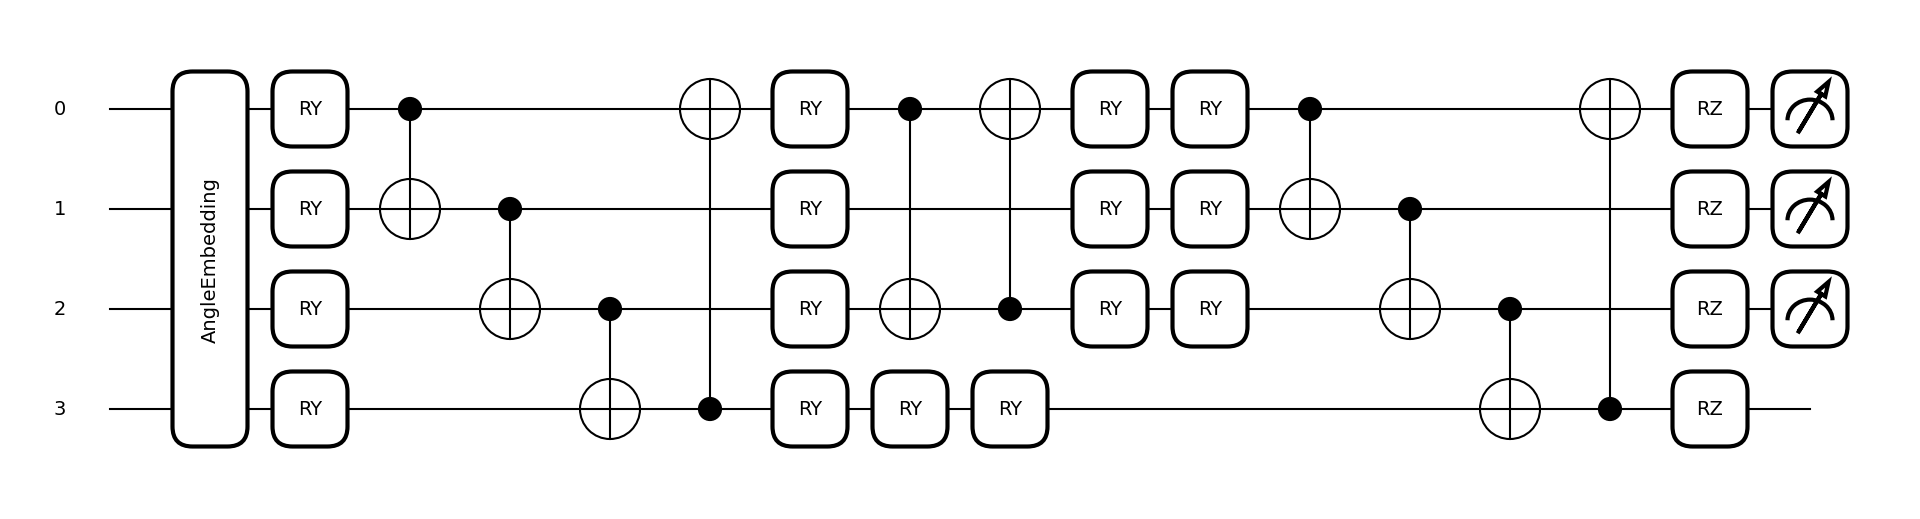

In [35]:
weights = np.random.random(size=(n_layers, total_weights))
fig, ax = qml.draw_mpl(qnode)(X_train[:, :4], weights)
plt.show()

In [36]:
n_layers = 1
n_qubits=3
total_weights_long = 32
print("Total weights required:", total_weights_long)

weight_shapes_long = {"weights": (n_layers, total_weights_long+1)}

Total weights required: 32


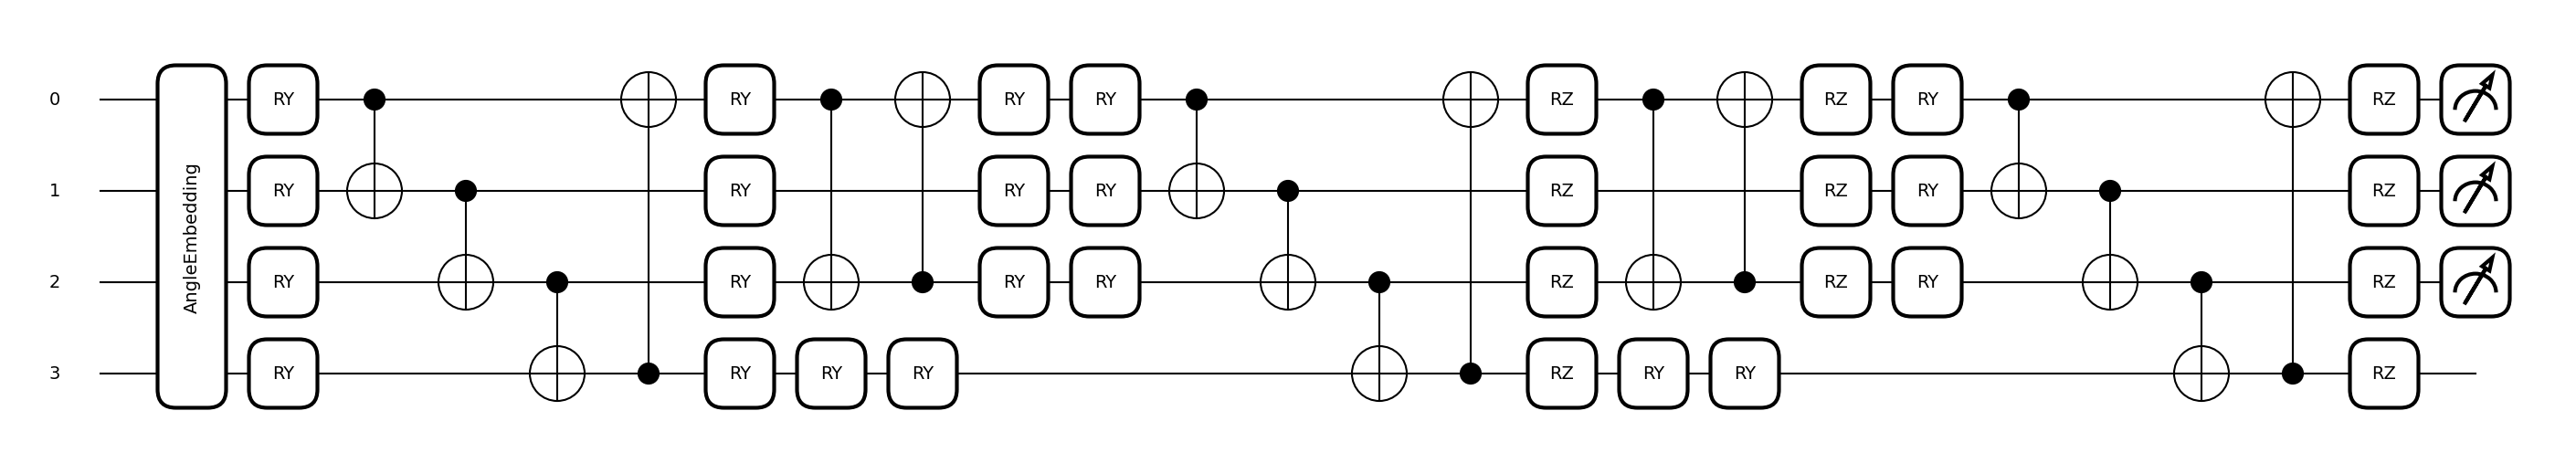

In [37]:
weights = np.random.random(size=(n_layers, total_weights_long))
fig, ax = qml.draw_mpl(qnode_long)(X[:, :4], weights)

plt.show()

In [38]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2025-01-30 19:24:32.379246: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-30 19:24:32.379768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [39]:
qlayer_long = qml.qnn.KerasLayer(qnode_long, weight_shapes_long, output_dim=n_qubits)

# Checking The Influence of Quantum Model

For this to be implemented we lowered the amount of data used to have a faster run of the quantum circuit

In [40]:
from sklearn.metrics import classification_report

In [41]:
n_layers = 1
n_qubits=3
total_weights_long = 32
print("Total weights required:", total_weights_long)

weight_shapes_long = {"weights": (n_layers, total_weights_long+1)}

Total weights required: 32


In [42]:
qlayer_long = qml.qnn.KerasLayer(qnode_long, weight_shapes_long, output_dim=n_qubits)

In [50]:
import os
import json
os.makedirs("../experiment_4", exist_ok=True) 
for i in range(5):
    print(f"Iteration {i+1}")

    # Classic model
    classic_model = Sequential([
        Dense(4, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
        Dense(2, activation=tf.nn.softmax)
    ])
    classic_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    with tf.device('/CPU:0'):
        classical_history=classic_model.fit(X_train, y_train, validation_split=0.2, batch_size=512, epochs=3, shuffle=True, verbose=1)
    eval.evaluate_model(classic_model, X_test, y_test)
    # Save entire model (architecture + weights)
    classic_model.save(f"../experiment_4/classic_model_iteration_{i+1}.h5")
    # Save only the weights
    classic_model.save_weights(f"../experiment_4/classic_model_iteration_{i+1}_weights.h5")
    
        # Save training history as JSON
    with open(f"../experiment_4/classic_model_iteration_{i+1}_history.json", "w") as f:
        json.dump(classical_history.history, f)
    print("Evaluating Quantum Model")
    print("====================================================================================================================================")



    quantum_model = Sequential([
        Dense(4, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
        qlayer,
        Dense(2, activation=tf.nn.softmax)
    ])

    quantum_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    with tf.device('/CPU:0'):
        quantum_history=quantum_model.fit(X_train, y_train, validation_split=0.2, batch_size=512, epochs=3, shuffle=True, verbose=1)
    
    eval.evaluate_model(quantum_model, X_test, y_test)
    
    # Save entire model
    quantum_model.save(f"../experiment_4/quantum_model_iteration_{i+1}.h5")
    # Save only the weights
    quantum_model.save_weights(f"../experiment_4/quantum_model_iteration_{i+1}_weights.h5")

    # Save training history as JSON
    with open(f"../experiment_4/quantum_model_iteration_{i+1}_history.json", "w") as f:
        json.dump(quantum_history.history, f)
    
    print("====================================================================================================================================")


Iteration 1
Epoch 1/3


/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2025-01-30 19:33:35.157146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2838/2849 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9717

2025-01-30 19:33:41.274236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2849/2849 [==============================] - 7s 2ms/step - loss: 0.0922 - accuracy: 0.9717 - val_loss: 0.0712 - val_accuracy: 0.9774
Epoch 2/3
2849/2849 [==============================] - 7s 2ms/step - loss: 0.0604 - accuracy: 0.9802 - val_loss: 0.0528 - val_accuracy: 0.9830
Epoch 3/3
 147/4748 [..............................] - ETA: 4s

2025-01-30 19:33:56.024235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4748/4748 [==============================] - 5s 1ms/step
Confusion Matrix:
[[550438   1713]
 [  8625  46907]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    552151
         1.0       0.96      0.84      0.90     55532

    accuracy                           0.98    607683
   macro avg       0.97      0.92      0.95    607683
weighted avg       0.98      0.98      0.98    607683


Accuracy: 0.9829878406998386
Recall: 0.8446841460779371
F1 Score: 0.9007412243643905
Evaluating Quantum Model
Epoch 1/3
   1/2849 [..............................] - ETA: 4:41 - loss: 0.5445 - accuracy: 0.8945

/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2849/2849 [==============================] - 232s 82ms/step - loss: 0.0744 - accuracy: 0.9753 - val_loss: 0.0509 - val_accuracy: 0.9828
Epoch 2/3
2849/2849 [==============================] - 231s 81ms/step - loss: 0.0473 - accuracy: 0.9835 - val_loss: 0.0441 - val_accuracy: 0.9842
Epoch 3/3
4748/4748 [==============================] - 104s 22ms/step
Confusion Matrix:
[[550869   1282]
 [  8127  47405]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.97      0.85      0.91     55532

    accuracy                           0.98    607683
   macro avg       0.98      0.93      0.95    607683
weighted avg       0.98      0.98      0.98    607683


Accuracy: 0.9845165982922017
Recall: 0.8536519484261327
F1 Score: 0.9097189571959048
Iteration 2
Epoch 1/3


/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2025-01-30 19:47:17.724704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2833/2849 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9754

2025-01-30 19:47:24.102986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2849/2849 [==============================] - 7s 3ms/step - loss: 0.0743 - accuracy: 0.9755 - val_loss: 0.0424 - val_accuracy: 0.9858
Epoch 2/3
2849/2849 [==============================] - 7s 2ms/step - loss: 0.0393 - accuracy: 0.9869 - val_loss: 0.0365 - val_accuracy: 0.9875
Epoch 3/3
 156/4748 [..............................] - ETA: 4s

2025-01-30 19:47:39.018579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4748/4748 [==============================] - 5s 1ms/step
Confusion Matrix:
[[548847   3304]
 [  3195  52337]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    552151
         1.0       0.94      0.94      0.94     55532

    accuracy                           0.99    607683
   macro avg       0.97      0.97      0.97    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.9893052792327579
Recall: 0.9424656054166967
F1 Score: 0.9415415613503278
Evaluating Quantum Model
Epoch 1/3
   1/2849 [..............................] - ETA: 4:49 - loss: 0.5620 - accuracy: 0.9238

/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2849/2849 [==============================] - 238s 83ms/step - loss: 0.0872 - accuracy: 0.9711 - val_loss: 0.0585 - val_accuracy: 0.9818
Epoch 2/3
2849/2849 [==============================] - 238s 84ms/step - loss: 0.0545 - accuracy: 0.9816 - val_loss: 0.0493 - val_accuracy: 0.9836
Epoch 3/3
4748/4748 [==============================] - 105s 22ms/step
Confusion Matrix:
[[549965   2186]
 [  8020  47512]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.96      0.86      0.90     55532

    accuracy                           0.98    607683
   macro avg       0.97      0.93      0.95    607683
weighted avg       0.98      0.98      0.98    607683


Accuracy: 0.9832050592167297
Recall: 0.8555787653965281
F1 Score: 0.9030124489214102
Iteration 3
Epoch 1/3


/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  44/2849 [..............................] - ETA: 6s - loss: 0.4365 - accuracy: 0.8667 

2025-01-30 20:01:17.225605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2828/2849 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9685

2025-01-30 20:01:23.297349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2849/2849 [==============================] - 7s 2ms/step - loss: 0.0992 - accuracy: 0.9685 - val_loss: 0.0653 - val_accuracy: 0.9794
Epoch 2/3
2849/2849 [==============================] - 7s 2ms/step - loss: 0.0539 - accuracy: 0.9819 - val_loss: 0.0476 - val_accuracy: 0.9837
Epoch 3/3
 153/4748 [..............................] - ETA: 4s

2025-01-30 20:01:38.063004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4748/4748 [==============================] - 5s 978us/step
Confusion Matrix:
[[549792   2359]
 [  6376  49156]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.95      0.89      0.92     55532

    accuracy                           0.99    607683
   macro avg       0.97      0.94      0.96    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.9856257292042068
Recall: 0.8851833177267161
F1 Score: 0.9184003288275243
Evaluating Quantum Model
Epoch 1/3
   1/2849 [..............................] - ETA: 4:48 - loss: 1.9669 - accuracy: 0.1172

/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2849/2849 [==============================] - 242s 85ms/step - loss: 0.1263 - accuracy: 0.9563 - val_loss: 0.0670 - val_accuracy: 0.9781
Epoch 2/3
2849/2849 [==============================] - 246s 86ms/step - loss: 0.0573 - accuracy: 0.9808 - val_loss: 0.0457 - val_accuracy: 0.9825
Epoch 3/3
4748/4748 [==============================] - 127s 27ms/step
Confusion Matrix:
[[550523   1628]
 [  4882  50650]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.97      0.91      0.94     55532

    accuracy                           0.99    607683
   macro avg       0.98      0.95      0.97    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.9892871776896836
Recall: 0.912086724771303
F1 Score: 0.9396159910954457
Iteration 4
Epoch 1/3


/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  35/2849 [..............................] - ETA: 8s - loss: 0.6020 - accuracy: 0.7908

2025-01-30 20:16:12.190167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2841/2849 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9738

2025-01-30 20:16:19.525625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2849/2849 [==============================] - 9s 3ms/step - loss: 0.0824 - accuracy: 0.9738 - val_loss: 0.0458 - val_accuracy: 0.9834
Epoch 2/3
2849/2849 [==============================] - 8s 3ms/step - loss: 0.0404 - accuracy: 0.9864 - val_loss: 0.0372 - val_accuracy: 0.9871
Epoch 3/3
 122/4748 [..............................] - ETA: 5s

2025-01-30 20:16:37.564562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4748/4748 [==============================] - 6s 1ms/step
Confusion Matrix:
[[549864   2287]
 [  3634  51898]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.96      0.93      0.95     55532

    accuracy                           0.99    607683
   macro avg       0.98      0.97      0.97    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.9902564330415694
Recall: 0.9345602535475042
F1 Score: 0.9460338871824786
Evaluating Quantum Model
Epoch 1/3
   1/2849 [..............................] - ETA: 5:04 - loss: 0.3995 - accuracy: 0.8887

/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2849/2849 [==============================] - 248s 87ms/step - loss: 0.0753 - accuracy: 0.9763 - val_loss: 0.0440 - val_accuracy: 0.9849
Epoch 2/3
2849/2849 [==============================] - 253s 89ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 3/3
4748/4748 [==============================] - 123s 26ms/step
Confusion Matrix:
[[551288    863]
 [  6449  49083]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.98      0.88      0.93     55532

    accuracy                           0.99    607683
   macro avg       0.99      0.94      0.96    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.987967410640087
Recall: 0.8838687603543902
F1 Score: 0.9306774872485257
Iteration 5
Epoch 1/3


/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  35/2849 [..............................] - ETA: 8s - loss: 0.3226 - accuracy: 0.9279

2025-01-30 20:31:33.538598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2843/2849 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9791

2025-01-30 20:31:41.027492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2849/2849 [==============================] - 9s 3ms/step - loss: 0.0626 - accuracy: 0.9791 - val_loss: 0.0401 - val_accuracy: 0.9864
Epoch 2/3
2849/2849 [==============================] - 8s 3ms/step - loss: 0.0376 - accuracy: 0.9868 - val_loss: 0.0339 - val_accuracy: 0.9854
Epoch 3/3
 120/4748 [..............................] - ETA: 5s

2025-01-30 20:31:59.288655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4748/4748 [==============================] - 6s 1ms/step
Confusion Matrix:
[[550260   1891]
 [  5071  50461]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    552151
         1.0       0.96      0.91      0.94     55532

    accuracy                           0.99    607683
   macro avg       0.98      0.95      0.96    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.9885433688288137
Recall: 0.9086832817114456
F1 Score: 0.9354677245930815
Evaluating Quantum Model
Epoch 1/3
   1/2849 [..............................] - ETA: 5:22 - loss: 0.4073 - accuracy: 0.8438

/Users/epameinondasdouros/Personal/Quantum/Code/Final_Project/q_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2849/2849 [==============================] - 260s 91ms/step - loss: 0.0794 - accuracy: 0.9740 - val_loss: 0.0480 - val_accuracy: 0.9824
Epoch 2/3
2849/2849 [==============================] - 250s 88ms/step - loss: 0.0447 - accuracy: 0.9848 - val_loss: 0.0442 - val_accuracy: 0.9870
Epoch 3/3
4748/4748 [==============================] - 115s 24ms/step
Confusion Matrix:
[[548077   4074]
 [  3058  52474]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    552151
         1.0       0.93      0.94      0.94     55532

    accuracy                           0.99    607683
   macro avg       0.96      0.97      0.96    607683
weighted avg       0.99      0.99      0.99    607683


Accuracy: 0.9882636177085751
Recall: 0.9449326514442123
F1 Score: 0.936366880799429


In [350]:
import pandas as pd

# Assuming X_train, Y_train, and X_test are your datasets
# Convert them to DataFrames if they are not already
X_train_df = pd.DataFrame(X_train)
Y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
# Save the datasets to CSV files

X_train_df.to_csv('X_train.csv', index=False)
Y_train_df.to_csv('y_train.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)